# Example Application: Indian Hindustani Music
March 2021

Here we walk through an example application in Indian Hindustani Music using the Hindustani Saraga Collection as available in MIRDATA - https://github.com/mir-dataset-loaders/mirdata.

We will go from the raw audio of a performance of Indian Art Music of the Hindustani tradition to an output of top N repeated motifs.

In [113]:
%load_ext autoreload
%autoreload 2

import IPython.display as ipd
import os
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.use('TkAgg')

import numpy as np
from scipy.ndimage import gaussian_filter1d
import essentia.standard as estd
import librosa

from spleeter.separator import Separator
from spleeter.audio.adapter import AudioAdapter

from src.utils import get_timestamp, interpolate_below_length
from src.visualisation import plot_all_sequences, double_timeseries, plot_subsequence
from src.iam import unpack_saraga_metadata
from src.io import write_all_sequence_audio, write_json, load_json, load_yaml, load_tonic
from src.sequence import contains_silence, too_stable, start_with_silence, min_gap
from src.matrix_profile import get_matrix_profile
from src.motif import get_motif_clusters, get_exclusion_mask
from src.pitch import cents_to_pitch, pitch_seq_to_cents, pitch_to_cents

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Recording and Metadata

Path to recording directory in `mir_datasets` (downloaded from - https://github.com/mir-dataset-loaders/mirdata)

In [115]:
mir_datasets_dir = '/Users/thomasnuttall/mir_datasets/saraga_hindustani/saraga1.5_hindustani/'

Path to recording and metadata

In [116]:
# Raag Todi - Kumar Gandharva

recording_dir = "Raag Bhairav & Dhani by Kumar Gandharva/Raag Bhairav/"

audio_file = "Raag Bhairav.mp3.mp3"
metadata_file = "Raag Bhairav.json"
tonic_file = "Raag Bhairav.ctonic.txt"

In [117]:
audio_path = os.path.join(mir_datasets_dir, recording_dir, audio_file)
metadata_path = os.path.join(mir_datasets_dir, recording_dir, metadata_file)
tonic_path = os.path.join(mir_datasets_dir, recording_dir, tonic_file)

In [118]:
metadata = load_json(metadata_path)
tonic = load_tonic(tonic_path)

In [119]:
print(f"Title: {metadata['title']}")
print(f"Artist: {metadata['artists'][0]['artist']['name']}")

Title: Raag Bhairav
Artist: Kumar Gandharva


## 2. Predominant Pitch Extraction

In [120]:
sampling_rate = 44100 # defined on load in next cell
frameSize = 2048 # For Melodia pitch extraction
hopSize = 128 # For Melodia pitch extraction
gap_interp = 250*0.001 # Interpolate pitch tracks gaps of <gap_interp>seconds or less [set to None to skip]
smooth = 7 # sigma for gaussian smoothing of pitch track [set to None to skip]

In [121]:
# load raw audio for display later
audio_loaded, sr = librosa.load(audio_path, sr=sampling_rate)

/Users/thomasnuttall/.virtualenvs/CMMR/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [122]:
# Run spleeter on track to remove the background
separator = Separator('spleeter:2stems')
audio_loader = AudioAdapter.default()
waveform, _ = audio_loader.load(audio_path, sample_rate=sampling_rate)
prediction = separator.separate(waveform=waveform)
clean_vocal = prediction['vocals']

INFO:tensorflow:Apply unet for vocals_spectrogram


[2021-06-16 11:29:20,590] INFO [tensorflow.apply_unet:100] Apply unet for vocals_spectrogram


INFO:tensorflow:Apply unet for accompaniment_spectrogram


[2021-06-16 11:29:23,197] INFO [tensorflow.apply_unet:100] Apply unet for accompaniment_spectrogram


INFO:tensorflow:Restoring parameters from pretrained_models/2stems/model


[2021-06-16 11:30:04,824] INFO [tensorflow.restore:1293] Restoring parameters from pretrained_models/2stems/model


In [123]:
# Prepare audio for pitch extraction
audio_mono = clean_vocal.sum(axis=1) / 2
audio_mono_eqloud = estd.EqualLoudness(sampleRate=sampling_rate)(audio_mono)

# Extract pitch using Melodia algorithm from Essentia
pitch_extractor = estd.PredominantPitchMelodia(frameSize=frameSize, hopSize=hopSize)
raw_pitch, _ = pitch_extractor(audio_mono_eqloud)
raw_pitch_ = np.append(raw_pitch, 0.0)
time = np.linspace(0.0, len(audio_mono_eqloud) / sampling_rate, len(raw_pitch))

timestep = time[4]-time[3] # resolution of time track

In [124]:
# Gap interpolation
if gap_interp:
    raw_pitch = interpolate_below_length(raw_pitch_, 0, int(gap_interp/timestep))
    
# Gaussian smoothing
if smooth:
    pitch = gaussian_filter1d(raw_pitch, smooth)
else:
    pitch = raw_pitch[:]

## 3. Melodic Exploration

The process for identifying repeated patterns in our pitch contour is as follows

- **Minimum in Matrix Profile + Subsequence Search**
    - Compute self-similarity Matrix Profile (MP) of pitch contour
    - Identify top N minimas in MP
    - Query entire pitch contour with patterns identified at minimas
    - Return those matches with a distance below some threshold
    - Number of characteristic subsequences == Number of minimas found in MP

The process relies on the Stumpy [1] matrix profiling package, using z-normalised euclidean distance for similarity.

[1] https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html
[2] https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

### 3.1 Compute Matrix Profile

`m_secs` - Specify desired sequence length (seconds), or pass a list and search for all of these lengths

In [125]:
m_secs = 8

# Convert to elements
if isinstance(m_secs, list):
    m_el = [int(x/timestep) for x in m_secs]
else:
    m_el = int(m_secs/timestep)

Compute or load matrix profile if it has been cached before

In [126]:
cache_dir = os.path.join(recording_dir, '.matrix_profile', f'gap_interp={gap_interp}__smooth={smooth}','')
matrix_profile, matrix_profile_length = get_matrix_profile(pitch, m_el, path=cache_dir)

Computing MP for subsequence length 2756
    time=8.26 minutes
caching at Raag Bhairav & Dhani by Kumar Gandharva/Raag Bhairav/.matrix_profile/gap_interp=0.25__smooth=7/


First 87.07 seconds of pitch and matrix profile


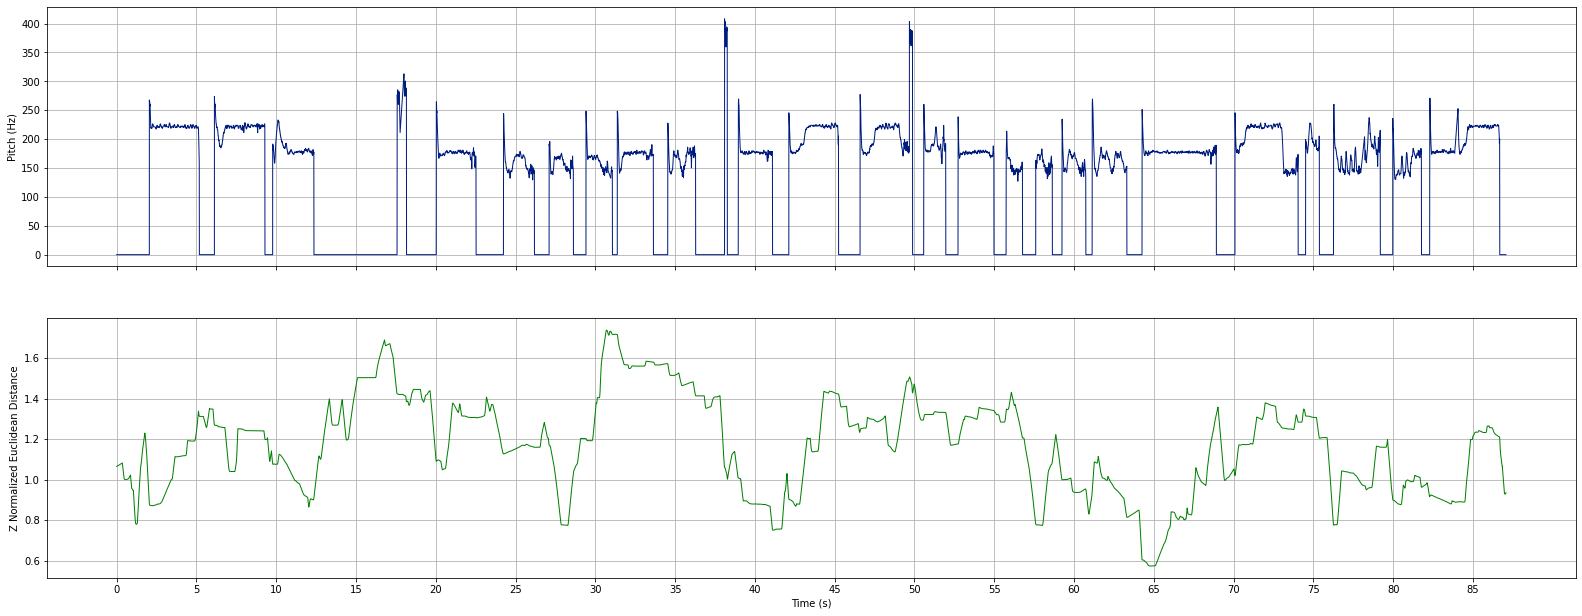

In [127]:
s = 30000 # Visualise first <sam> elements of pitch track and matrix profile
print(f'First {round(s*timestep,2)} seconds of pitch and matrix profile')
fig, ax = double_timeseries(
    time[:s], raw_pitch[:s], matrix_profile[:s], y1label='Pitch (Hz)', 
    y2label='Z Normalized Euclidean Distance', xlabel='Time (s)')

### 3.2 Identify Minima

In [128]:
# Maximum number of unique motif groups to return
top_n = 15

# Maximum number of occurrences to return in each motif group
n_occ = 20

# Minimum number of occurrences to return in each motif group
min_occ = 3

`exclusion_funcs` is a list of functions, each should take a sequence as an input and return `True` or `False` whether that sequence should be excluded from consideration or not. These functions are applied in advance to every subsequence in the pitch track to create a mask of sequences to skip when identifying minima.

For optimal run time when computing the exclusion mask, the functions in the list should be ordered from least -> most computationally expensive.

Pass a path to `exclusion_mask` to cache in that directory

In [130]:
exclusion_funcs = [contains_silence, too_stable]

In [131]:
# Can take some time depending on exclusion_funcs
exclusion_cache_path = os.path.join(cache_dir + f'.exclusion_mask/{str(m_el)}/')
exclusion_mask = get_exclusion_mask(pitch, matrix_profile_length, exclusion_funcs, path=exclusion_cache_path)

100%|██████████| 502189/502189 [1:08:52<00:00, 121.51it/s]


caching exclusion mask


In [132]:
print(f'{round(sum(exclusion_mask)*100/len(exclusion_mask), 2)}% subsequences excluded')

90.43% subsequences excluded


Find motif clusters from minimas in matrix profile. Returns...

`motifs` - array of `top_n` motif cluters x `n_occ` occurences in each cluster, each element is the start point of the sequence in the pitch track. 

`distances` - corresponding array of euclidean distances between each sequence and its parent sequence (the minima in matrix profile).

In [139]:
thresh = 0.65 # patterns with parent distances above this threshold are not considered
motifs, distances, motif_len = get_motif_clusters(matrix_profile, pitch, matrix_profile_length, top_n, n_occ, exclusion_mask, thresh=thresh, min_occ=min_occ)

5 occurrences in motif group 0 (length, 2756)
3 occurrences in motif group 1 (length, 2756)
3 occurrences in motif group 2 (length, 2756)
3 occurrences in motif group 3 (length, 2756)
3 occurrences in motif group 4 (length, 2756)


## 4. Explore Results

Explore pitch plots of returned motif groups. `plot_kwargs` allows you to configure the following
- `yticks_dict` - a dictionary of `{tick name:tick location}`, if specified, the y axis ticks will correspond with these only
- `cents` - True/False, if True, convert y axis of pitch into cents above `tonic`
- `tonic` - Tonic in Hz, only relevant if `cents` is `True`
- `emphasize` - A list of tick names in `ytick_dict` to emphasize in the plot (e.g. the tonic)
- `figsize` - Figure size of returned plot
- `ylim` - tuple of y-axis limits, `(min, max)`. If `None`, infer from data
- `xlim` - tuple of x-axis limits, `(min, max)`. If `None`, infer from data
- `title` - string, title
- `grid` - bool, include gridlines?
- `xlabel` - string, x-axis label (automatically inferred if `None`)
- `ylabel` - string, y-axis label (automatically inferred if `None`)

Iterate through the pitch plots to determine a suitable minimum euclidean distance to parent threshold (`thresh`)

In [135]:
plot_kwargs = {
    'yticks_dict':{},
    'cents':True,
    'tonic':tonic,
    'emphasize':[],
    'figsize':(15,4)#,
    #'ylim':(0, 1400),
    #title=None, 
    #xlabel=None,
    #ylabel=None, 
    #grid=True, 
    #ylim=None, 
    #xlim=None
}

Select which motif group to explore (out of `top_n` groups)

In [140]:
# Which motif group to display
motif_group = 2
l = motif_len[motif_group]

Cycle through all plots. The motif is indicated in the plot as the shaded region/yellow line. The preceeding/succeeding areas are included for context. The audio player below each plot displays the audio corresponding to the shaded region (i.e. the returned motif)

Occurence 0 in motif group 2, 2min 36.64sec
Distance to parent: 0.0


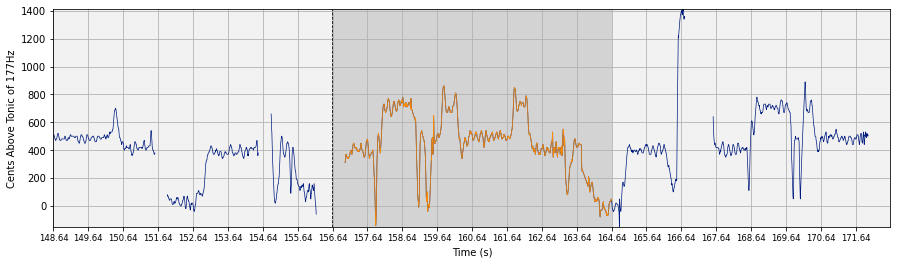

Occurence 1 in motif group 2, 3min 29.71sec
Distance to parent: 0.49365668402340585


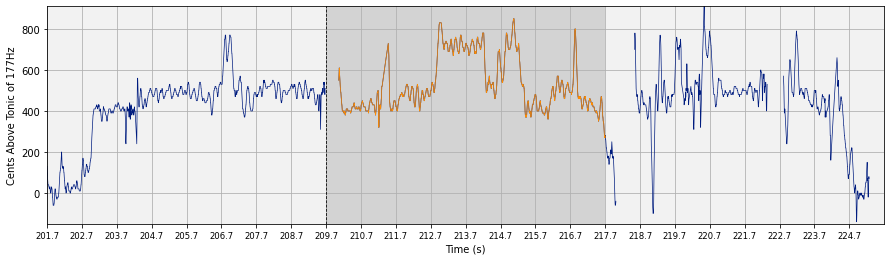

Occurence 2 in motif group 2, 6min 39.32sec
Distance to parent: 0.6288472156534571


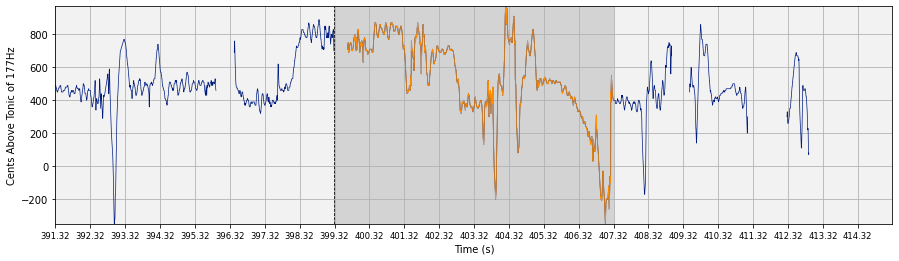

In [141]:
for i,m in enumerate(motifs[motif_group], 0):
    print(f"Occurence {i} in motif group {motif_group}, {get_timestamp(time[m], ' ')}")
    print(f'Distance to parent: {distances[motif_group][i]}')
    p = plot_subsequence(m, l, raw_pitch, time, timestep, plot_kwargs=plot_kwargs)
    p.show()
    t1 = int(m*timestep*sampling_rate)
    t2 = int((m+l)*timestep*sampling_rate)
    ipd.display(ipd.Audio(audio_loaded[t1:t2], rate=sampling_rate))
plt.close('all')

## 5. Output Plots and Audio

Output all plots and audio samples for each motif group to `out_dir`.

In [142]:
# If the directory does not exist, it will be created
out_dir = f'../output/indian_hindustani/artist={album_artists}__title={title}__concert={concert}_pattern_length={m_secs}/'
print(out_dir)

../output/indian_hindustani/artist=Kumar Gandharva__title=Raag Todi__concert=None_pattern_length=8/


Write plots for all subsequences

If `clear_dir` is `True` and the direcotry exists, all files will be deleted.

In [143]:
plot_all_sequences(raw_pitch, time, motif_len, motifs, out_dir, distances=distances, clear_dir=True, plot_kwargs=plot_kwargs)

Write audio for all subsequences

In [144]:
write_all_sequence_audio(audio_path, motifs, motif_len, timestep, out_dir)

/Users/thomasnuttall/.virtualenvs/CMMR/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [145]:
parameters = {
    'top_n': top_n,
    'n_occ':n_occ,
    'min_occ':min_occ,
    'thresh':thresh,
    'sampling_rate': sampling_rate,
    'frameSize': frameSize,
    'hopSize': hopSize,
    'gap_interp': gap_interp,
    'smooth': smooth
}
write_json(parameters, os.path.join(out_dir, 'parameters.json'))